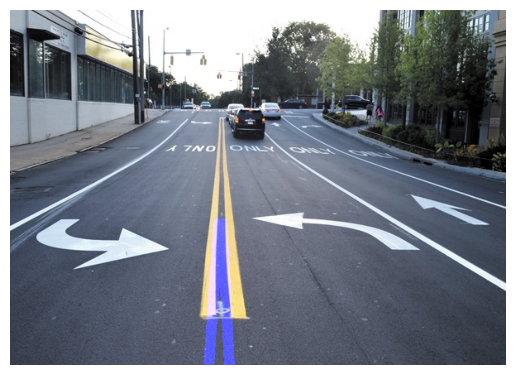

Moviepy - Building video output_videos/output_video.mp4.
Moviepy - Writing video output_videos/output_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/output_video.mp4


In [27]:
import cv2
import numpy as np
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt

def list_images(images, cols=2, rows=5, cmap=None):
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def HSL_color_selection(image):
    converted_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    lower_white = np.array([0, 200, 0], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)
    white_mask = cv2.inRange(converted_image, lower_white, upper_white)

    lower_yellow = np.array([10, 0, 100], dtype=np.uint8)
    upper_yellow = np.array([40, 255, 255], dtype=np.uint8)
    yellow_mask = cv2.inRange(converted_image, lower_yellow, upper_yellow)

    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    return masked_image

def gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def gaussian_smoothing(image, kernel_size=5):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def canny_detector(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

def region_selection(image):
    mask = np.zeros_like(image)
    rows, cols = image.shape[:2]
    bottom_left = [cols * 0.1, rows * 0.95]
    top_left = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def hough_transform(image):
    rho = 1
    theta = np.pi / 180
    threshold = 20
    min_line_length = 20
    max_line_gap = 300
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)

def average_slope_intercept(lines):
    left_lines = []
    left_weights = []
    right_lines = []
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append(length)
            else:
                right_lines.append((slope, intercept))
                right_weights.append(length)

    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

def pixel_points(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)

def frame_processor(image):
    color_select = HSL_color_selection(image)
    gray = gray_scale(color_select)
    smooth = gaussian_smoothing(gray)
    edges = canny_detector(smooth)
    region = region_selection(edges)
    hough = hough_transform(region)
    result = draw_lane_lines(image, lane_lines(image, hough))
    return result

def process_video(test_video, output_video):
    input_video = VideoFileClip(test_video)
    processed = input_video.fl_image(frame_processor)
    processed.write_videofile(output_video, audio=False)

# Load and display a single image for testing
test_image = cv2.imread('test_images/road2.jpg')
output_image = frame_processor(test_image)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Process video and create output
process_video('test_videos/challenge.mp4', 'output_videos/output_video.mp4')